<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/Comptech_val_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

МОЯ копия версии Артема

In [ ]:
import pandas as pd
import itertools
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
import pickle

In [ ]:
!pip install httpx

     |████████████████████████████████| 84 kB 896 kB/s 
     |████████████████████████████████| 67 kB 2.1 MB/s 
     |████████████████████████████████| 79 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 729 kB/s 


In [ ]:
def get_cases(days):
  import httpx
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/cases_{days}.pickle").content
  return pickle.loads(data)

In [ ]:
def get_lags(days):
  import json
  import httpx
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/lags_{days}.json").content
  return json.loads(data)

In [ ]:
def get_predict(predict_country, lags, predict_days, cases, use_filter=False):
    predict = np.zeros(predict_days)
    weights = 0
    field_name = ("filtered_" if use_filter else "") + "history"
    mean_predict_country = cases[predict_country][field_name][-predict_days:].mean()

    for country, desc in lags[predict_country].items():
        days_lag = -desc["lag"]  # т.к. всегда отрицательная величина
        if days_lag <= predict_days:
            continue
        
        cases_prev_days = cases[country][field_name].iloc[-days_lag: -days_lag + predict_days]
        coef = (mean_predict_country / cases_prev_days.mean())
        weight = np.sqrt(desc["similarity"])
        case = cases_prev_days.values * coef * weight
        
        if len(case) == predict_days:
          weights += weight
          predict += case
    
    if weights != 0:
        return predict / weights
    else:
        return predict

In [ ]:
days = [30, 60, 90]

In [ ]:
cases_30, cases_60, cases_90 = (get_cases(i) for i in days)

In [ ]:
lags_30, lags_60, lags_90 = (get_lags(i) for i in days)

In [ ]:
cases_30.keys()

dict_keys(['China', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Bangladesh', 'Qatar', 'Afghanistan', 'Romania', 'Russia', 'Rwanda', 'Bahrain', 'Saudi Arabia', 'Paraguay', 'Oman', 'Panama', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'Nigeria', 'Belgium', 'North Macedonia', 'Norway', 'Azerbaijan', 'Pakistan', 'Belarus', 'Serbia', 'Slovenia', 'Singapore', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'US', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Algeria', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam', 'Albania', 'Thailand', 'Austria', 'Slovakia', 'Mongolia', 'South Africa', 'Australia', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Argentina', 'Armenia', 'Moldova', 'Ethiopia', 'Finland', 'France', 'Canada', 'Georgia', 'Germany', 'Ghana', 'Cameroon', 'Greece', 'Guatemala', 'Estonia', 'Costa Rica', 'Croatia', 'Colombia', 'Cuba', 'Cyprus', 'Cambodia', 'Czechia', 'Dominican Republic', 'Chile', 'Ecuador', 'Egypt', 'El Salvador', 'Denma

In [ ]:
cases_30["China"].keys()

dict_keys(['filtered_history', 'filtered_validate', 'validate', 'history'])

In [ ]:
df_dict = {30: (cases_30, lags_30), 60: (cases_60, lags_60)}#, 90:(cases_90, lags_90)}

In [ ]:
# А теперь попробую сразу посмотреть как с несколькими датасетами справится движок
def validator_dict(model, df_dict, use_filter=True):
    result = {}
    mape = []
    
    for days, lst in df_dict.items():
      cases, lags = lst
      for country in lags.keys():
        if country == "Russia":
          y_true = cases[country][f"{'filtered_' if use_filter else ''}validate"]
          y_pred = model(country, lags, days, cases, use_filter)
          #return y_true, y_pred
          if any(y_pred != y_pred) or any(y_pred == 0) or any(y_true == 0):
              continue

          mape.append(mean_absolute_percentage_error(y_true, y_pred))

      result[str(days) + ' days'] = np.array(mape).mean()

    return result

In [ ]:
validator_dict(get_predict, df_dict, True)

{'30 days': 0.7353281351108056, '60 days': 0.9140387173449508}

In [ ]:
%matplotlib inline

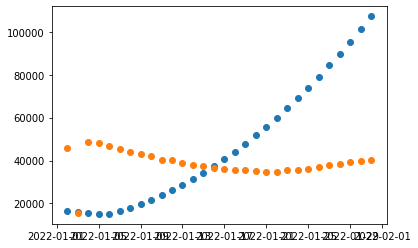

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(true_.index, true_.values)
plt.scatter(true_.index, pred_)

In [ ]:
validator_dict(get_predict, df_dict, False)

Last_Update
2022-01-03     18088.0
2022-01-04     16193.0
2022-01-05     15760.0
2022-01-06     15632.0
2022-01-07     15179.0
2022-01-08     16608.0
2022-01-09     16424.0
2022-01-10     16111.0
2022-01-11     15699.0
2022-01-12     17396.0
2022-01-13     17797.0
2022-01-14     20972.0
2022-01-15     23614.0
2022-01-16     26949.0
2022-01-17     28977.0
2022-01-18     30457.0
2022-01-19     30959.0
2022-01-20     33571.0
2022-01-21     38508.0
2022-01-22     49127.0
2022-01-23     56767.0
2022-01-24     62695.0
2022-01-25     64533.0
2022-01-26     67219.0
2022-01-27     74072.0
2022-01-28     88105.0
2022-01-29     97284.0
2022-01-30    112302.0
2022-01-31    120324.0
2022-02-01    123033.0
Name: Confirmed, dtype: float64
[   35248.22091335    32857.96333683    35005.40269201    33097.63971328
    26373.96619895    38117.49478347    30067.20640149    30972.58992402
    27121.94650366    31478.63299758    26594.21456529    21697.53499932
    31717.12995399    29895.06808143    23478.6

{'30 days': 3.2215511788281472,
 '60 days': 2.1178172476052177,
 '90 days': 2.1178172476052177}